# Set Up

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from netcoloc import network_colocalization, netprop_zscore
import seaborn as sns

In [3]:
from analysis_functions import *
from plotting_functions import *
from updated_netcoloc_functions import *

In [4]:
DATADIR= '~/Data/rat/data/final/'# location of input datasets
OUTDIR= '/cellar/users/snwright/Data/Transfer/rat/' # path to save intermediate and final datasets
ratThresh='relaxed'
num_reps=1000
mapper='PASCAL'
adj_type='bonf'
rerun_analysis=False

In [5]:

def calculate_significance_colocalized_network(z_dict, seed_dict, num_permutations=100, verbose=True, zthresh=3,
                                              overlap_control=None, d1=None, d2=None):
    """
    :param z_dict:
    :param seed_dict:
    :param num_permutations:
    :param verbose:
    :param zthresh:
    """

    focal_diseases = list(z_dict.keys())
    focal_diseases.reverse()
    # get all combinations of diseases
    focal_combinations = itertools.combinations(focal_diseases, 2)
    # set up data frame to store results
    network_overlap = pd.DataFrame({"trait_pair": focal_combinations})
    network_overlap = network_overlap.reindex(columns=["num_overlap", "obs_exp", "pval_overlap", 
                                                       "exp_mean_overlap", "exp_std_overlap"], 
                                              index = network_overlap.trait_pair.values)
    # iterate over trait pairs
    for trait_pair in network_overlap.index.values:
        #extract the two traits
        d1, d2 = trait_pair
        # get the associated seed genes
        seed1 = seed_dict[d1]
        seed2 = seed_dict[d2]
        # get the z scores following network propagation
        z1=z_dict[d1]
        z2=z_dict[d2] 
        if overlap_control == "remove":
            overlapping_seeds = np.intersect1d(seed1,seed2)
            z1_noseeds = z1.drop(overlapping_seeds, axis=0, inplace=True)
            z2_noseeds = z2.drop(overlapping_seeds, axis=0, inplace=True)
        elif overlap_control == "bin":
            overlapping_seeds = np.intersect1d(seed1,seed2)
            overlap_z1 = z1.loc[overlapping_seeds]
            overlap_z2 = z2.loc[overlapping_seeds]
            z1_noseeds = z1.drop(overlapping_seeds, axis=0, inplace=True)
            z2_noseeds = z2.drop(overlapping_seeds, axis=0, inplace=True)

        if preserve_topology == False:   
            # perform permutations to calculate expected size of colocalized network
            if overlap_control in ["remove", "bin"]:
                z_d1d2_size,high_z_rand=network_colocalization.calculate_expected_overlap(z1_noseeds['z'],z2_noseeds['z'],
                                                                                      plot=False,num_reps=num_permutations,
                                                                                      z_score_threshold=zthresh,
                                                                                      z1_threshold=1.0,
                                                                                      z2_threshold=1.0)
                if overlap_control == "bin":
                    z_d1d2_size_overlap, high_z_rand_overlap = network_colocalization.calculate_expected_overlap(overlap_z1['z'],overlap_z2['z'],
                                                                                      plot=False,num_reps=num_permutations,
                                                                                      z_score_threshold=zthresh,
                                                                                      z1_threshold=1.0,
                                                                                      z2_threshold=1.0)
                    z_d1d2_size += z_d1d2_size_overlap
                    high_z_rand = list(np.array(high_z_rand) + np.array(high_z_rand_overlap))
            else:
                z_d1d2_size,high_z_rand=network_colocalization.calculate_expected_overlap(z1['z'],z2['z'],
                                                                                      plot=False,num_reps=num_permutations,
                                                                                      z_score_threshold=zthresh,
                                                                                      z1_threshold=1.0,
                                                                                      z2_threshold=1.0)
        # store statistics in results table
        ztemp = (z_d1d2_size-np.mean(high_z_rand))/np.std(high_z_rand)
        ptemp = norm.sf(ztemp)
        obs_exp_temp = float(z_d1d2_size)/np.mean(high_z_rand)
    
        network_overlap.loc[[trait_pair]] = [z_d1d2_size,obs_exp_temp, ptemp,np.mean(high_z_rand), np.std(high_z_rand)]
        if verbose:
            print(d1+' + '+d2+'\ninclude seeds')
            print('overlapping seeds = '+str(len(np.intersect1d(seed1,seed2))))
            print("Observed overlap:", z_d1d2_size)
            print("Observed/expected:",obs_exp_temp)
            print("Probability of observed", ptemp)
            print('\n')   
        
    return(network_overlap)

## Added to netcoloc
def calculate_expected_overlap(z_scores_1, z_scores_2, seed1=None, seed2=None, 
                               z_score_threshold=3, z1_threshold=1.5,
                               z2_threshold=1.5,
                               num_reps=1000, plot=False, overlap_control=None):
    """
    Determines size of expected network overlap by randomly
    shuffling gene names

    :param z_scores_1: Result from :py:func:`~netcoloc.netprop_zscore.netprop_zscore`
                       or :py:func:`~netcoloc.netprop_zscore.calculate_heat_zscores`
                       containing the z-scores of each gene following network
                       propagation. The index consists of gene names
    :type z_scores_1: :py:class:`pandas.Series`
    :param z_scores_2: Similar to **z_scores_1**. This and **z_scores_1**
                       must contain the same genes (ie. come from the same
                       interactome network)
    :type z_scores_2: :py:class:`pandas.Series`
    :param z_score_threshold: threshold to determine whether a gene is
        a part of the network overlap or not. Genes with combined z-scores
        below this threshold will be discarded
    :type z_score_threshold: float
    :param z1_threshold: individual z1-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z1-scores
        below this threshold will be discarded
    :type z1_threshold: float
    :param z2_threshold: individual z2-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z2-scores
        below this threshold will be discarded
    :type z2_threshold: float
    :param num_reps:
    :param plot: If ``True``, distribution will be plotted
    :type plot: bool
    :return:
    :rtype: float
    """
    # Build a distribution of expected network overlap sizes by shuffling node names
    random_network_overlap_sizes = []
    if isinstance(z_scores_1, pd.DataFrame):
        z1z2 = z_scores_1.join(z_scores_2, lsuffix="1", rsuffix="2")
        z1z2 = z1z2.assign(zz=z1z2.z1 * z1z2.z2)
    elif isinstance(z_scores_1, pd.Series):
        z1z2 = pd.concat([z_scores_1, z_scores_2], axis=1)
    if overlap_control == "remove":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    elif overlap_control == "bin":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        overlap_z1z2 = z1z2.loc[seed_overlap]
        overlap_z1 = np.array(overlap_z1z2.z1)
        overlap_z2 = np.array(overlap_z1z2.z2)
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    z1 = np.array(z1z2.z1)
    z2 = np.array(z1z2.z2)
    
    network_overlap_size = len(calculate_network_overlap(z1z2.z1, z1z2.z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
    network_overlap_size += len(calculate_network_overlap(overlap_z1z2.z1, overlap_z1z2.z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
    
    random_network_overlap_sizes = np.zeros(num_reps)
    for i in tqdm(range(num_reps)):
        perm_z1z2 = np.zeros(len(z1))
        rn.shuffle(z1)
        perm_size = len(calculate_network_overlap(z1, z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
        if overlap_control == "bin":
            overlap_perm_z1z2 = np.zeros(len(overlap_z1))
            rn.shuffle(overlap_z1) 
            perm_size_overlap = len(calculate_network_overlap(overlap_z1, overlap_z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
            
            perm_size += perm_size_overlap
                    
        
        random_network_overlap_sizes[i] = perm_size
    

    if plot:
        plt.figure(figsize=(5, 4))
        dfig = sns.histplot(random_network_overlap_sizes,
                            label='Expected network intersection size')
        plt.vlines(network_overlap_size, ymin=0, ymax=dfig.dataLim.bounds[3], color='r',
                   label='Observed network intersection size')
        plt.xlabel('Size of proximal subgraph, z > ' + str(z_score_threshold),
                   fontsize=16)
        plt.legend(fontsize=12)

    return network_overlap_size, random_network_overlap_sizes

     
def plot_overlap_significance(primary, secondary, results_table):
    """
    :param primary:
    :param secondary:
    :param results_table:
    """
    pairs = [(primary, s)  if (primary, s) in results_table.index else (s, primary) for s in secondary]
    pairs_data = results_table.loc[pairs]
    pairs_data['xlabel'] = [primary+ "-" + s for s in secondary]
    pairs_data['yerr_lower'] = pairs_data.apply(lambda x: x.obs_exp - x.num_overlap/(x.exp_mean_overlap + 1.96*x.exp_std_overlap), axis = 1)
    pairs_data['yerr_upper'] = pairs_data.apply(lambda x: x.num_overlap/(x.exp_mean_overlap - 1.96*x.exp_std_overlap) - x.obs_exp, axis = 1)

    plt.figure(figsize = (4,3))
    plt.errorbar(np.arange(len(pairs_data)),pairs_data['obs_exp'],
             yerr=[pairs_data['yerr_lower'],pairs_data['yerr_upper']],
             fmt='o',color='k')
    tmp=plt.xticks(np.arange(len(pairs_data)), pairs_data['xlabel'],fontsize=16,rotation='vertical')
    plt.ylabel('observed/expected size \nof network intersection\n(95% CI)',fontsize=16)
    plt.hlines(1,xmin=-.5,xmax=len(pairs_data),color='gray',linestyles='dashed')
    plt.yticks(fontsize=16)
    plt.xlim([-.5,len(pairs_data)-.5])
    
def plot_permutation_histogram(permuted, observed, title, xlabel, color="cornflowerblue", arrow_color="red"):
    """
    Plot the observed mean of NPS_hr against a density histrogram of the means of permuted NPS_hr
    :param permuted: Vector of means of permuted NPS_hr
    :param observed: Observed mean of NPS_hr
    :param title: String for plot title
    :param xlabel: String for x-axis label
    """
    plt.figure(figsize=(5, 4))
    dfig = sns.histplot(permuted, label='Permuted', alpha=0.4, stat='density', bins=25, kde=True, 
                        edgecolor='w', color=color)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    plt.xlabel(xlabel, fontsize=16)
    diff = max(observed, max(permuted))-min(permuted)
    plt.arrow(x = observed, y=dfig.dataLim.bounds[3]/2, dx=0, dy = -1 * dfig.dataLim.bounds[3]/2,label = "Observed",
              width=diff/100, head_width=diff/15, head_length=dfig.dataLim.bounds[3]/20, overhang=0.5, 
              length_includes_head=True, color=arrow_color, zorder=50)
    #plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=12, loc=(0.6,0.75))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.locator_params(axis="y", nbins=6)
    plt.title(title+" (p="+str(get_p_from_permutation_results(observed, permuted))+")", fontsize=16)

## Added to netcoloc
def get_p_from_permutation_results(observed, permuted):
    """
    Calculates the significance of the observed mean relative to the empirical normal distribution of permuted means.
    :param observed: observed mean NPS_hr
    :param permuted: vector of means from permuted NPS_hr
    """
    p = norm.sf((observed-np.mean(permuted))/np.std(permuted))
    p = round(p, 4 - int(math.floor(math.log10(abs(p)))) - 1)
    return(p)


## Added to netcoloc
def calculate_network_overlap(z_scores_1, z_scores_2, z_score_threshold=3,
                              z1_threshold=1.5, z2_threshold=1.5):
    """
    Function to determine which genes overlap. Returns a list of the
    overlapping genes

    :param z_scores_1: Result from :py:func:`~netcoloc.netprop_zscore.netprop_zscore`
                       or :py:func:`~netcoloc.netprop_zscore.calculate_heat_zscores`
                       containing the z-scores of each gene following network
                       propagation. The index consists of gene names
    :type z_scores_1: :py:class:`pandas.Series`
    :param z_scores_2: Similar to **z_scores_1**. This and **z_scores_1**
                       must contain the same genes (ie. come from the same
                       interactome network)
    :type z_scores_2: :py:class:`pandas.Series`
    :param z_score_threshold: threshold to determine whether a gene is
        a part of the network overlap or not. Genes with combined z-scores
        below this threshold will be discarded
    :type z_score_threshold: float
    :param z1_threshold: individual z1-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z1-scores
        below this threshold will be discarded
    :type z1_threshold: float
    :param z2_threshold: individual z2-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z2-scores
        below this threshold will be discarded
    :type z2_threshold: float
    :return: genes in the network overlap (genes with high combined
            z-scores)
    :rtype: list
    """
    if isinstance(z_scores_1, pd.Series):
        z_scores_1 = z_scores_1.to_frame(name='z_scores_1')
        z_scores_2 = z_scores_2.to_frame(name='z_scores_2')
    elif isinstance(z_scores_1, np.ndarray):
        z_scores_1 = pd.DataFrame({"z_scores_1":z_scores_1})
        z_scores_2 = pd.DataFrame({"z_scores_2":z_scores_2})
    else:
        z_scores_1.columns = ["z_scores_1"]
        z_scores_2.columns = ["z_scores_2"]
    z_scores_joined = z_scores_1.join(z_scores_2)
    z_scores_combined = (z_scores_joined['z_scores_1']
                        * z_scores_joined['z_scores_2']
                        * (z_scores_joined['z_scores_1'] > 0)
                        * (z_scores_joined['z_scores_2'] > 0))
    # get rid of unlikely genes which have low scores in either z1 or z2
    high_z_score_genes = z_scores_combined[
        (z_scores_combined >= z_score_threshold)
         & (z_scores_joined['z_scores_1'] > z1_threshold)
         & (z_scores_joined['z_scores_2'] > z2_threshold)
    ].index.tolist()

    return high_z_score_genes


In [6]:
def plot_trait_bar(obs, perm, ci=0.95):
    transform = np.mean(perm) / perm
    avg = np.mean(transform)
    upper = np.quantile(transform, ci)
    lower = np.quantile(transform, 1-ci)
    observation = obs / np.mean(perm)
    p_value = get_p_from_permutation_results(obs, perm)
    plt.bar(["observed", "permuted"], [observation, avg], yerr=[[0, avg - lower], [0, upper- avg]], capsize=4,edgecolor="black")

def plot_control_bar(obs, perm, trait, ci=0.95):
    transform = obs / perm
    avg = np.mean(transform)
    upper = np.quantile(transform, ci)
    lower = np.quantile(transform, 1-ci)
    p_value = get_p_from_permutation_results(obs, perm)
    return pd.DataFrame({"Mean":avg, "Upper":upper, "Lower":lower, "p":p_value}, index=[trait])
    #plt.bar(["control"], [avg], yerr=[[avg-lower], [upper-avg]])    

In [7]:
def load_human_seed_genes(filepath, interactome_nodes, trait=''):
    """
    :param filepath:
    :param interactome_nodes:
    :param trait:
    """
    all_scores = pd.read_csv(filepath, sep="\t", index_col='gene_symbol')
    # subset to genes in the interactome
    all_scores = all_scores.loc[list(np.intersect1d(all_scores.index.tolist(), interactome_nodes))]
    # Calculate bonferroni corrected pvalue (alpha=0.05)
    bonf_p = .05/len(all_scores)
    # Get significant genes
    seeds = all_scores[all_scores['pvalue'] < bonf_p].index.tolist()
    print("Number of",trait,"seeds:", len(seeds))
    return seeds

In [19]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [20]:
# Human BMI seed genes
seed_bin_human_BMI = load_human_seed_genes(DATADIR+'GIANT_BMI_pascal.sum.genescores.txt', 
                                           pc_nodes, 'BMI')
# Human standing height seed genes
seed_bin_human_height = load_human_seed_genes(DATADIR+'GIANT_standing_height_pascal.sum.genescores.txt', 
                                              pc_nodes, 'height')

Number of BMI seeds: 1958
Number of height seeds: 6140


In [21]:
seed_bin_rat_BL=pd.read_csv(DATADIR+'ratBL_seed_'+ratThresh+'.txt',sep='\t')['0'].tolist()
print("Number of rat BL seeds:", len(seed_bin_rat_BL))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'ratBMI_seed_'+ratThresh+'.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of rat BL seeds: 337
Number of rat BMI seeds: 295


In [60]:
# Human control trait seed genes
seed_bin_human_AR = pd.read_csv(DATADIR+'humanAR_seed_'+mapper+'_'+adj_type+'_'+ratThresh+'.txt',
                               sep="\t")['0'].tolist() # Arthritis
seed_bin_human_BP1 = pd.read_csv(DATADIR+'humanBP1_seed_'+mapper+'_'+adj_type+'_'+ratThresh+'.txt',
                               sep="\t")['0'].tolist() # Balding pattern 1
seed_bin_human_BP4 = pd.read_csv(DATADIR+'humanBP4_seed_'+mapper+'_'+adj_type+'_'+ratThresh+'.txt',
                               sep="\t")['0'].tolist() # Balding pattern 4
print("Number of AR seeds:", len(seed_bin_human_AR))
print("Number of BP1 seeds:", len(seed_bin_human_BP1))
print("Number of BP4 seeds:", len(seed_bin_human_BP4))

Number of AR seeds: 34
Number of BP1 seeds: 316
Number of BP4 seeds: 239


In [61]:
z_human_bin_BMI = netprop_zscore.get_consensus_z_scores(DATADIR+'z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')
z_human_bin_height = netprop_zscore.get_consensus_z_scores(DATADIR+'z_human_bin_Height_SAMPLED_500_100_weighted.tsv')
out_name = 'rat_BMI_'+ratThresh
z_rat_BMI=pd.read_csv(DATADIR+'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                          index_col='gene',names=['gene','z'], header=0)
out_name = 'rat_BL_'+ratThresh
z_rat_BL=pd.read_csv(DATADIR + 'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                         index_col='gene', names=['gene', 'z'], header=0)

In [62]:
out_name = 'human_AR_'+mapper+'_'+adj_type
z_human_bin_AR=pd.read_csv(DATADIR+'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)

out_name = 'human_BP1_'+mapper+'_'+adj_type
z_human_bin_BP1=pd.read_csv(DATADIR+'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)

out_name = 'human_BP4_'+mapper+'_'+adj_type
z_human_bin_BP4=pd.read_csv(DATADIR+'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)

In [63]:
z_dict = {'hBMI':z_human_bin_BMI,'hHeight':z_human_bin_height,
          'rBMI':z_rat_BMI,'rBL':z_rat_BL,
          'hAR':z_human_bin_AR,'hBP1':z_human_bin_BP1,
          'hBP4':z_human_bin_BP4}

seed_dict = {'hBMI':seed_bin_human_BMI,'hHeight':seed_bin_human_height,
             'rBMI':seed_bin_rat_BMI,'rBL':seed_bin_rat_BL,
             'hAR':seed_bin_human_AR,'hBP1':seed_bin_human_BP1,
             'hBP4':seed_bin_human_BP4}

# Do Analysis

In [64]:
control_results = []

In [65]:
obs_a, perm_a = calculate_expected_overlap(z_dict['rBMI'], z_dict['hAR'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['hAR'])

Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 72.59it/s]


Significance of colocalized network size: 0.9998


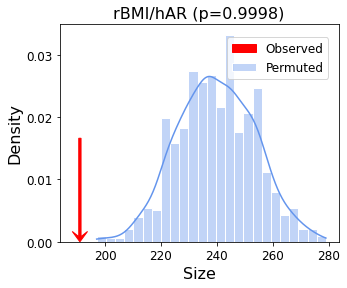

In [66]:

control_results.append(plot_control_bar(obs_a, perm_a, "hAR"))
plot_permutation_histogram(perm_a, obs_a,'rBMI/hAR', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_a, perm_a))

In [67]:
obs_b, perm_b = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBP1'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['hBP1'])

Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 72.66it/s]


Significance of colocalized network size: 0.47


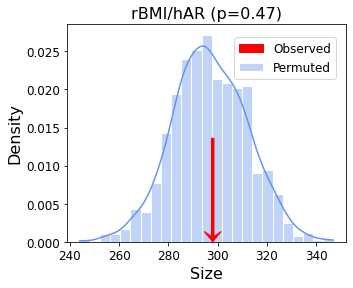

In [68]:
control_results.append(plot_control_bar(obs_b, perm_b, "hBP1"))
plot_permutation_histogram(perm_b, obs_b,'rBMI/hAR', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_b, perm_b))

In [69]:
obs_c, perm_c = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBP4'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['hBP4'])

Overlap seed genes: 1


100%|██████████| 1000/1000 [00:13<00:00, 72.45it/s]


Significance of colocalized network size: 0.9677


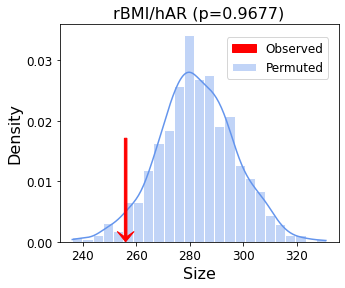

In [70]:
control_results.append(plot_control_bar(obs_c, perm_c, "hBP4"))
plot_permutation_histogram(perm_c, obs_c,'rBMI/hAR', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_c, perm_c))

In [71]:
obs_d, perm_d = calculate_expected_overlap(z_dict['rBMI'], z_dict['hHeight'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['hHeight'])

Overlap seed genes: 109


100%|██████████| 1000/1000 [00:13<00:00, 73.34it/s]


Significance of colocalized network size: 0.9454


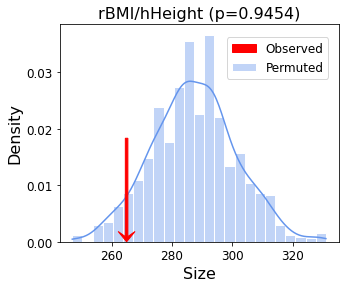

In [72]:
control_results.append(plot_control_bar(obs_d, perm_d, "hHeight"))
plot_permutation_histogram(perm_d, obs_d,'rBMI/hHeight', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_d, perm_d))

In [73]:
obs_e, perm_e = calculate_expected_overlap(z_dict['rBMI'], z_dict['rBL'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['rBL'])

Overlap seed genes: 25


100%|██████████| 1000/1000 [00:13<00:00, 73.33it/s]


Significance of colocalized network size: 9.112e-08


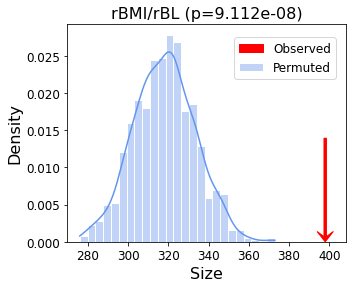

In [74]:
control_results.append(plot_control_bar(obs_e, perm_e, "rBL"))
plot_permutation_histogram(perm_e, obs_e,'rBMI/rBL', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_e, perm_e))

In [75]:
obs_f, perm_f = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBMI'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 1000/1000 [00:13<00:00, 72.86it/s]


Significance of colocalized network size: 2.251e-08


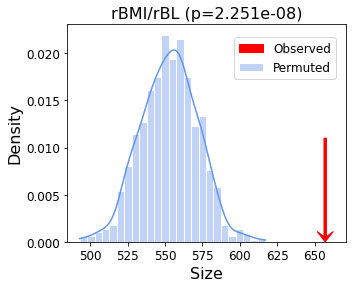

In [76]:
control_results.append(plot_control_bar(obs_f, perm_f, "hBMI"))
plot_permutation_histogram(perm_f, obs_f,'rBMI/rBL', 'Size')
print("Significance of colocalized network size:", get_p_from_permutation_results(obs_f, perm_f))

In [77]:
obs_g, perm_g = calculate_expected_overlap(z_dict['rBL'], z_dict['hBMI'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBL'], seed2=seed_dict['hBMI'])

Overlap seed genes: 57


100%|██████████| 1000/1000 [00:13<00:00, 73.04it/s]


In [78]:
control_results.append(plot_control_bar(obs_g, perm_g, "rBL/hBMI"))

In [79]:
obs_h, perm_h = calculate_expected_overlap(z_dict['rBL'], z_dict['hHeight'], 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin",
                                                                              seed1=seed_dict['rBL'], seed2=seed_dict['hHeight'])

Overlap seed genes: 166


100%|██████████| 1000/1000 [00:13<00:00, 72.71it/s]


In [80]:
control_results.append(plot_control_bar(obs_h, perm_h, "hBL/Height"))


In [81]:
control_results = pd.concat(control_results)

In [82]:
control_results

,Mean,Upper,Lower,p
hAR,0.799305,0.876349,0.729008,9.998000e-01
hBP1,1.006463,1.091776,0.925466,4.700000e-01
hBP4,0.908276,0.992248,0.833876,9.677000e-01
hHeight,0.924681,1.003788,0.852090,9.454000e-01
rBL,1.254009,1.358362,1.156977,9.112000e-08
hBMI,1.189800,1.258621,1.126930,2.251000e-08
rBL/hBMI,1.222049,1.283761,1.158861,9.124000e-13
hBL/Height,1.384310,1.469880,1.301333,1.434000e-24


## Rat STRING network

In [15]:
# process ortholog mappings from HCOP
ortho_map = pd.read_csv("human_rat_hcop_fifteen_column.txt.gz", sep="\t", index_col=None)
# restrict to entries with symbols for both species
ortho_map = ortho_map[(ortho_map["human_symbol"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_symbol"] != "-")]
# restrict to entries with chromosome information
ortho_map = ortho_map[(ortho_map["human_chr"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_chr"] != "-")]
# quantify number of supporting sources
ortho_map["N_sources"] = ortho_map.support.apply(lambda x: len(x.split(",")))
ortho_map = ortho_map.sort_values(by=["human_symbol", "N_sources"])
ortho_map.head()

,human_entrez_gene,human_ensembl_gene,hgnc_id,human_name,human_symbol,human_chr,human_assert_ids,rat_entrez_gene,rat_ensembl_gene,rgd_id,rat_name,rat_symbol,rat_chr,rat_assert_ids,support,N_sources
517,1,ENSG00000121410,HGNC:5,alpha-1-B glycoprotein,A1BG,19q13.43,"HUMAN|HGNC=5|UniProtKB=P04217,P04217,ENSG00000...",140656,ENSRNOG00000004692,RGD:69417,alpha-1-B glycoprotein,A1bg,7,"RAT|RGD=69417|UniProtKB=Q9EPH1,Q9EPH1,ENSRNOG0...","Panther,Inparanoid,Ensembl,HomoloGene,Treefam,...",8
519,29974,ENSG00000148584,HGNC:24086,APOBEC1 complementation factor,A1CF,10q11.23,"HUMAN|HGNC=24086|UniProtKB=Q9NQ94,Q9NQ94,ENSG0...",170912,ENSRNOG00000033195,RGD:619834,APOBEC1 complementation factor,A1cf,1,"RAT|RGD=619834|UniProtKB=Q923K9,Q923K9,ENSRNOG...","Panther,Inparanoid,Ensembl,HomoloGene,EggNOG,O...",9
523,2,ENSG00000175899,HGNC:7,alpha-2-macroglobulin,A2M,12p13.31,HUMAN|HGNC=7|UniProtKB=P01023,408236,ENSRNOG00000065574,RGD:1302962,murinoglobulin 2,Mug2,4,RAT|RGD=1302962|UniProtKB=Q6IE52,Panther,1
524,2,ENSG00000175899,HGNC:7,alpha-2-macroglobulin,A2M,12p13.31,13407at9347,252922,ENSRNOG00000006709,RGD:628643,pregnancy-zone protein,Pzp,4,13407at9347,OrthoDB,1
521,2,ENSG00000175899,HGNC:7,alpha-2-macroglobulin,A2M,12p13.31,"HUMAN|HGNC=7|UniProtKB=P01023,13407at9347",297568,ENSRNOG00000070375,RGD:1584999,alpha-1-inhibitor III,LOC297568,4,"RAT|RGD=1584999|UniProtKB=P14046,13407at9347","Panther,OrthoDB",2


In [9]:
interactome_uuid='880c7d8c-f5ad-11ec-ac45-0ac135e8bacf' # for PCNet
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_rat_HC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes_rat_HC = list(G_rat_HC.nodes)

    # pcnet appears to have some self edges... should remove them. 
G_rat_HC.remove_edges_from(nx.selfloop_edges(G_rat_HC))

    # print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_rat_HC.nodes))
print('\nnumber of edges:')
print(len(G_rat_HC.edges))

number of nodes:
16787

number of edges:
277852


In [10]:
# remove unconnected nodes
remove_nodes = [n[0] for n in G_rat_HC.degree() if n[1]==0]
G_rat_HC.remove_nodes_from(remove_nodes)

In [43]:
# load z_scores
z_rat_bmi_rat_net = pd.read_csv("Data/outputs/rat_string_rat_zscores.tsv", header=None, sep="\t", index_col=0, names=["z"])
z_human_bin_BMI_rat_HC = netprop_zscore.get_consensus_z_scores("Data/outputs/rat_string_HC_BMIsampling_500_100.tsv", 0.75)

In [22]:
# map human BMI to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_human_BMI)]
# take ortholog supported by largest number of databases
seed_human_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                          keep="last", ignore_index=True).loc[:, ("human_symbol", "rat_symbol")] 

In [24]:
# map rat BMI back to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_rat_BMI)]
# take ortholog supported by largest number of databases
seed_rat_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                        keep="last", ignore_index=True).rat_symbol.unique() 

In [50]:
z_rat_bmi_rat_net.index.name=None

In [47]:
seeds_rat = [n for n in seed_rat_bmi_rat_orthos if n in nodes_rat_HC]
seeds_human = [n for n in seed_human_bmi_rat_orthos.rat_symbol.unique() if n in nodes_rat_HC]

observed_BMI, permuted_BMI = calculate_mean_z_score_distribution(z_rat_bmi_rat_net.fillna(0), 
                                                                 z_human_bin_BMI_rat_HC.fillna(0), num_reps=1000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed1=seeds_rat, seed2=seeds_human)

               z1        z2        zz
Foxo3   -0.318572  8.176169 -2.604697
Rps6kb2  0.574596  0.344198  0.197775
Mapk1    2.076539  1.437659  2.985355
Rps6kb1  0.478584  1.032921  0.494340
Rptor   -0.159442  5.616423 -0.895495
Overlap seed genes: 26


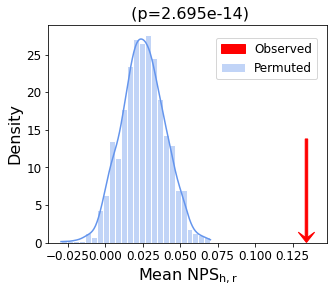

In [51]:
plot_permutation_histogram(permuted_BMI, observed_BMI,'', 'Mean $NPS_{h,r}$')#,color="dimgrey", arrow_color="#F5793A")

In [54]:
seeds_rat = [n for n in seed_rat_bmi_rat_orthos if n in nodes_rat_HC]
seeds_human = [n for n in seed_human_bmi_rat_orthos.rat_symbol.unique() if n in nodes_rat_HC]

observed_BMI, permuted_BMI = calculate_expected_overlap(z_rat_bmi_rat_net.fillna(0), 
                                                        z_human_bin_BMI_rat_HC.fillna(0), num_reps=1000,
                                                        overlap_control="bin",
                                                       seed1=seeds_rat, seed2=seeds_human)

Overlap seed genes: 26


100%|██████████| 1000/1000 [00:12<00:00, 79.71it/s]


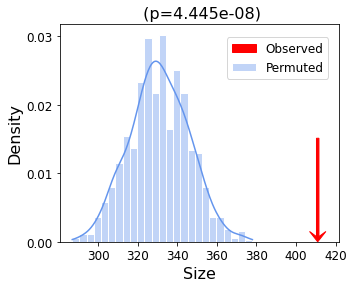

In [55]:
plot_permutation_histogram(permuted_BMI, observed_BMI,'', 'Size')

In [57]:
plot_control_bar(observed_BMI, permuted_BMI, "BMI_RatSTRING")

,Mean,Upper,Lower,p
BMI_RatSTRING,1.244483,1.338762,1.157584,4.445000e-08


In [83]:
control_results = pd.concat([control_results,plot_control_bar(observed_BMI, permuted_BMI, "BMI_RatSTRING") ])

In [84]:
control_results

,Mean,Upper,Lower,p
hAR,0.799305,0.876349,0.729008,9.998000e-01
hBP1,1.006463,1.091776,0.925466,4.700000e-01
hBP4,0.908276,0.992248,0.833876,9.677000e-01
hHeight,0.924681,1.003788,0.852090,9.454000e-01
rBL,1.254009,1.358362,1.156977,9.112000e-08
hBMI,1.189800,1.258621,1.126930,2.251000e-08
rBL/hBMI,1.222049,1.283761,1.158861,9.124000e-13
hBL/Height,1.384310,1.469880,1.301333,1.434000e-24
BMI_RatSTRING,1.244483,1.338762,1.157584,4.445000e-08


## Plot figures

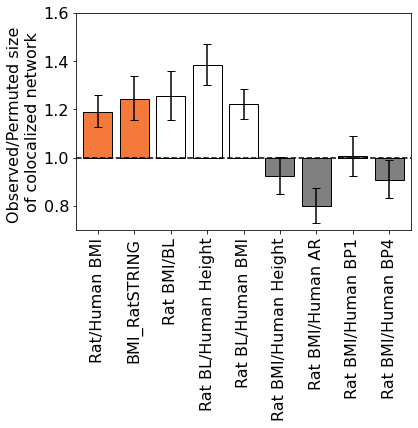

In [86]:
#plt.figure(figsize=(3, 4))
plot_results = control_results.loc[["hBMI", "BMI_RatSTRING","rBL", "hBL/Height", "rBL/hBMI", "hHeight", "hAR", "hBP1", "hBP4"]]
plt.bar(x = ["hBMI", "BMI_RatSTRING", "rBL", "hBL/Height", "rBL/hBMI", "hHeight", "hAR", "hBP1", "hBP4"],
       bottom= 1, height = plot_results.Mean - 1, capsize=4, edgecolor="black",
        yerr = [plot_results.Mean - plot_results.Lower, plot_results.Upper - plot_results.Mean],
       color = ["#f5793a"]*2 + ["white"]*3 + ["grey"]*4)

plt.xticks(fontsize=16, rotation=90, ticks=["hBMI", "BMI_RatSTRING", "rBL","hBL/Height", "rBL/hBMI", "hHeight", "hAR", "hBP1", "hBP4"], 
          labels = ["Rat/Human BMI",  "BMI_RatSTRING", "Rat BMI/BL", "Rat BL/Human Height", "Rat BL/Human BMI", "Rat BMI/Human Height",
                   "Rat BMI/Human AR", "Rat BMI/Human BP1", "Rat BMI/Human BP4"])
plt.ylabel("Observed/Permuted size \nof colocalized network", fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=8.6, linestyle="dashed", color="black")
plt.xlim(-0.6, 8.6)
plt.ylim(0.7, 1.6)
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/control_plot2_July1.png", bbox_inches="tight", dpi=400)

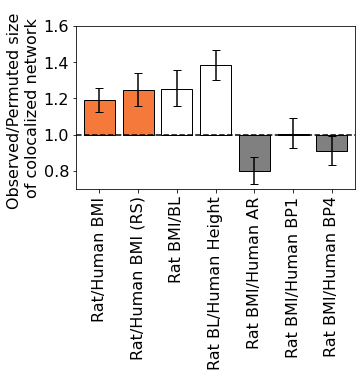

In [88]:
plt.figure(figsize=(5, 3))
plot_results = control_results.loc[["hBMI",  "BMI_RatSTRING","rBL", "hBL/Height", "hAR", "hBP1", "hBP4"]]
plt.bar(x = ["hBMI", "BMI_RatSTRING", "rBL", "hBL/Height", "hAR", "hBP1", "hBP4"],
       bottom= 1, height = plot_results.Mean - 1, capsize=4, edgecolor="black",
        yerr = [plot_results.Mean - plot_results.Lower, plot_results.Upper - plot_results.Mean],
       color = ["#f5793a"]*2 + ["white"]*2 + ["grey"]*3)

plt.xticks(fontsize=16, rotation=90, ticks=["hBMI", "BMI_RatSTRING", "rBL","hBL/Height", "hAR", "hBP1", "hBP4"], 
          labels = ["Rat/Human BMI", "Rat/Human BMI (RS)", "Rat BMI/BL", "Rat BL/Human Height",
                   "Rat BMI/Human AR", "Rat BMI/Human BP1", "Rat BMI/Human BP4"])
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=6.6, linestyle="dashed", color="black")
plt.ylabel("Observed/Permuted size \nof colocalized network", fontsize=16)
plt.xlim(-0.6, 6.6)
plt.ylim(0.7, 1.6)
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/control_plot_July1.png", bbox_inches="tight", dpi=400)